### Camera App 분석
---
- mkdir -p ~/aiffel/video_sticker_app/models  
    
  
- sudo apt install libgtk2.0-dev pkg-config  
- pip install cmake  
- pip install dlib  
- pip install opencv-contrib-python  
  
    
- wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 -P ~/aiffel/video_sticker_app/models/  
- bzip2 -d ~/aiffel/video_sticker_app/models/shape_predictor_68_face_landmarks.dat.bz2  

### 동영상에 스티커 붙이기 
- wget https://aiffelstaticprd.blob.core.windows.net/media/documents/video_sticker_app.zip -P ~/aiffel/video_sticker_app
- cd ~/aiffel/video_sticker_app && unzip video_sticker_app.zip

#### 동영상 처리 방법
- pip install moviepy

In [ ]:
# VideoFileClip 은 비디오 파일을 읽어올 때 사용되는 클래스 
from moviepy.editor import VideoFileClip
# ipython_display() 는 동영상을 주피터 노트북에 렌더링할 수 있게 도와주는 함수
from moviepy.editor import ipython_display

In [ ]:
import os
video_path = os.getenv('HOME')+'/aiffel/video_sticker_app/images/video2.mp4'
clip = VideoFileClip(video_path)
clip = clip.resize(width=640)
clip.ipython_display(fps=30, loop=True, autoplay=True, rd_kwargs=dict(logger=None))

#### 동영상 실행
- cd ~/aiffel/video_sticker_app && python videocheck.py


In [ ]:
# videocheck.py
import cv2

vc = cv2.VideoCapture('./images/video2.mp4')
# vc의 get() 함수로 읽을 수 있습니다. FRAME_COUNT 은 비디오 전체 프레임 개수
vlen = int(vc.get(cv2.CAP_PROP_FRAME_COUNT))
print (vlen) # video length

for i in range(vlen):
    # ret 은 read() 함수에서 이미지가 반환되면 True, 반대의 경우 False
    ret, img = vc.read()
    if ret == False:
        break

    cv2.imshow('show', img)
    # waitKey() 함수는 키보드가 입력될 때 키보드 값을 반환 27=esc
    key = cv2.waitKey(1)
    if key == 27:
        break

####  이미지 시퀀스에 스티커앱 적용하기
- wget https://aiffelstaticprd.blob.core.windows.net/media/documents/king.zip
- unzip king.zip -d ~/aiffel/video_sticker_app/images

In [ ]:
# addsticker.py
import dlib
import cv2

def img2sticker_orig(img_orig, img_sticker, detector_hog, landmark_predictor):
    # preprocess
    img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

    # detector
    dlib_rects = detector_hog(img_rgb, 0)
    if len(dlib_rects) < 1:
        return img_orig

    # landmark
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)

    # head coord
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        x = landmark[30][0] # nose
        y = landmark[30][1] - dlib_rect.width()//2
        w = dlib_rect.width()
        h = dlib_rect.width()
        break

    # sticker
    img_sticker = cv2.resize(img_sticker, (w,h), interpolation=cv2.INTER_NEAREST)

    refined_x = x - w // 2
    refined_y = y - h

    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:]
        refined_y = 0

    img_bgr = img_orig.copy()
    sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

    img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        cv2.addWeighted(sticker_area, 1.0, img_sticker, 0.7, 0)

    return img_bgr

In [ ]:
detector_hog = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor('./models/shape_predictor_68_face_landmarks.dat')

vc = cv2.VideoCapture('./images/video2.mp4')
img_sticker = cv2.imread('./images/king.png')

vlen = int(vc.get(cv2.CAP_PROP_FRAME_COUNT))
print (vlen) # 비디오 프레임의 총 개수

In [ ]:
for i in range(vlen):
    ret, img = vc.read()
    if ret == False:
        break

    ## 추가된 부분
    start = cv2.getTickCount()
    img_result = img2sticker_orig(img, img_sticker.copy(), detector_hog, landmark_predictor)
    time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000
    print ('[INFO] time: %.2fms'%time)

    cv2.imshow('show', img_result)
    key = cv2.waitKey(1)
    if key == 27:
        break

cv2.destroyAllWindows()

#### 스티커 붙이고 실행
- cd ~/aiffel/video_sticker_app && python addsticker.py

#### OpenCV로 동영상 저장하기
```
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
vw = cv2.VideoWriter('./images/result.mp4', fourcc, 30, (1280, 720))
```
#### 코덱 찾기
```
fourcc = int(vc.get(cv2.CAP_PROP_FOURCC))
fourcc_str = "%c%c%c%c"%(fourcc & 255, (fourcc >> 8) & 255, (fourcc >> 16) & 255, (fourcc >> 24) & 255)
print ("CAP_PROP_FOURCC: ", fourcc_str)
```

In [ ]:
# savevideo.py
detector_hog = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor('./models/shape_predictor_68_face_landmarks.dat')

vc = cv2.VideoCapture('./images/video2.mp4')
img_sticker = cv2.imread('./images/king.png')

vlen = int(vc.get(cv2.CAP_PROP_FRAME_COUNT))
print (vlen) # 비디오 프레임의 총 개수

# writer 초기화
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
vw = cv2.VideoWriter('./images/result.mp4', fourcc, 30, (1280, 720))

for i in range(vlen):
    ret, img = vc.read()
    if ret == False:
        break

    start = cv2.getTickCount()
    img_result = img2sticker_orig(img, img_sticker.copy(), detector_hog, landmark_predictor)
    time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000
    print ('[INFO] time: %.2fms'%time)

        # 매 프레임 마다 저장합니다.    
    vw.write(cv2.resize(img_result, (1280,720)))

    cv2.imshow('show', img_result)
    key = cv2.waitKey(1)
    if key == 27:
        break

vw.release()
cv2.destroyAllWindows()

#### 비디오에서 스티커작업 후 저장까지
- cd ~/aiffel/video_sticker_app && python savevideo.py

### 성능향상
#### 1) 실행시간 분석
- img2sticker_orig()함수
 1. 전처리 (Preprocess)
 2. 얼굴 검출 (Detection)
 3. 랜드마크 검출 (Landmark)
 4. 좌표변환 (Coord)
 5. 스티커 합성 (Sticker)

In [ ]:
# addstiker_timecheck.py
def img2sticker_orig(img_orig, img_sticker, detector_hog, landmark_predictor):
    # preprocess
    start = cv2.getTickCount()
    img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    preprocess_time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000

    # detector
    start = cv2.getTickCount()
    dlib_rects = detector_hog(img_rgb, 0)
    if len(dlib_rects) < 1:
        return img_orig
    detection_time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000

    # landmark
    start = cv2.getTickCount()
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
    landmark_time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000

    # head coord
    start = cv2.getTickCount()
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        x = landmark[30][0] # nose
        y = landmark[30][1] - dlib_rect.width()//2
        w = dlib_rect.width()
        h = dlib_rect.width()
        # x,y,w,h = [ele*2 for ele in [x,y,w,h]]
        break
    coord_time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000

    # sticker
    start = cv2.getTickCount()
    img_sticker = cv2.resize(img_sticker, (w,h), interpolation=cv2.INTER_NEAREST)

    refined_x = x - w // 2
    refined_y = y - h

    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:]
        refined_y = 0

    img_bgr = img_orig.copy()
    sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

    img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        cv2.addWeighted(sticker_area, 1.0, img_sticker, 0.7, 0)
    sticker_time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000

    print (f'p:{preprocess_time:.1f}ms, d:{detection_time:.1f}ms, l:{landmark_time:.1f}ms, c:{coord_time:.1f}ms, s:{sticker_time:.1f}ms')

    return img_bgr

#### 실행시간 측정
- cd ~/aiffel/video_sticker_app && python addsticker_timecheck.py

In [ ]:
# addstiker_modified.py
def img2sticker_orig(img_orig, img_sticker, detector_hog, landmark_predictor):
    # preprocess
    img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

    # detector
    # detector*와 landmark*에 입력되는 img_rgb 이미지를 VGA 크기로 1/4만큼 감소시킵니다.
    img_rgb_vga = cv2.resize(img_rgb, (640, 360))
    dlib_rects = detector_hog(img_rgb_vga, 0)
    if len(dlib_rects) < 1:
        return img_orig

    # landmark
    # 줄인만큼 스티커 위치를 다시 2배로 복원해야 합니다.
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb_vga, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)

    # head coord
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        x = landmark[30][0] # nose
        y = landmark[30][1] - dlib_rect.width()//2
        w = dlib_rect.width()
        h = dlib_rect.width()
        # 줄인 만큼 스티커 위치를 다시 2배로 복원해야 합니다.
        x,y,w,h = [ele*2 for ele in [x,y,w,h]]
        break

    # sticker
    img_sticker = cv2.resize(img_sticker, (w,h), interpolation=cv2.INTER_NEAREST)

    refined_x = x - w // 2
    refined_y = y - h

    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:]
        refined_y = 0

    img_bgr = img_orig.copy()
    sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

    img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        cv2.addWeighted(sticker_area, 1.0, img_sticker, 0.7, 0)

    return img_bgr

### 동영상 안정화(stabilizer) 설계
#### 칼만 필터 
- [Kalman filter 소개](https://medium.com/@celinachild/kalman-filter-%EC%86%8C%EA%B0%9C-395c2016b4d6)
![칼만](https://aiffelstaticprd.blob.core.windows.net/media/images/GC-7-L-13.max-800x600.png)  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

In [2]:
def get_pos_vel(idx, dt, init_pos=0, init_vel=20):
    w = np.random.normal(0, 1)                # w: system noise.
    v = np.random.normal(0, 2)                # v: measurement noise.

    vel_true = init_vel + w                   # nominal velocity = 80 [m/s].
    pos_true = init_pos + sum([vel_true*dt for i in range(idx)])
    z_pos_meas = pos_true + v                 # z_pos_meas: measured position (observable)
    
    return z_pos_meas, vel_true, pos_true#, v, w

In [3]:
for i in range(0,10):
    print (get_pos_vel(i, 1))

(-0.7249233130891777, 19.42611011641862, 0)
(24.540461256511453, 20.825403721578056, 20.825403721578056)
(42.24133978316232, 19.735058185581085, 39.47011637116217)
(65.78294680872008, 21.038168274875478, 63.11450482462644)
(81.57544519332366, 21.055060669390414, 84.22024267756166)
(103.587615216264, 21.145966311134924, 105.72983155567462)
(111.09935005946716, 18.669130747516043, 112.01478448509627)
(135.38960939601418, 19.272803100034412, 134.90962170024088)
(154.1664848392535, 19.58685722914946, 156.69485783319567)
(199.213701568116, 22.292227089477866, 200.63004380530083)


In [4]:
def kalman_filter(z, x, P):
# Kalman Filter Algorithm
    # 예측 단계
    xp = A @ x
    Pp = A @ P @ A.T + Q

    # 추정 단계
    K = Pp @ H.T @ inv(H @ Pp @ H.T + R)
    x = xp + K @ (z - H @ xp)
    P = Pp - K @ H @ Pp
    return x, P

In [5]:
# time param
time_end = 5
dt= 0.05

In [6]:
# init matrix
A = np.array([[1, dt],
                       [0, 1]]) # pos * 1 + vel * dt = 예측 위치
H = np.array([[1, 0]])



# Q : 시스템 오차(클 수록 오차공분산이 커져서 측정값을 더 신뢰)
Q = np.array([[1, 0],
                       [0, 1]])
# R : 측정 오차(칼만 이득에서 inv term이 존재하기 때문에 R이 커질수록 칼만 이득이 작아진다. 측정 오차가 클수록 시스템에 더 신뢰)
R = np.array([[200]])

In [7]:
# Initialization for estimation.
x_0 = np.array([0, 20])  # position and velocity
P_0 = 1 * np.eye(2)

In [8]:
time = np.arange(0, time_end, dt)
n_samples = len(time)
pos_meas_save = np.zeros(n_samples)
vel_true_save = np.zeros(n_samples)
pos_esti_save = np.zeros(n_samples)
vel_esti_save = np.zeros(n_samples)

In [9]:
pos_true = 0
x, P = None, None
for i in range(n_samples):
    z, vel_true, pos_true = get_pos_vel(i, dt)
    if i == 0:
        x, P = x_0, P_0
    else:
        x, P = kalman_filter(z, x, P)

    pos_meas_save[i] = z
    vel_true_save[i] = vel_true
    pos_esti_save[i] = x[0]
    vel_esti_save[i] = x[1]

Text(0, 0.5, 'Velocity [m/s]')

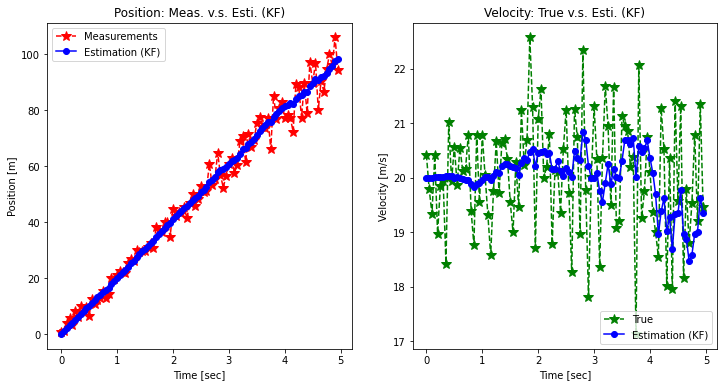

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(time, pos_meas_save, 'r*--', label='Measurements', markersize=10)
plt.plot(time, pos_esti_save, 'bo-', label='Estimation (KF)')
plt.legend(loc='upper left')
plt.title('Position: Meas. v.s. Esti. (KF)')
plt.xlabel('Time [sec]')
plt.ylabel('Position [m]')

plt.subplot(1, 2, 2)
plt.plot(time, vel_true_save, 'g*--', label='True', markersize=10)
plt.plot(time, vel_esti_save, 'bo-', label='Estimation (KF)')
plt.legend(loc='lower right')
plt.title('Velocity: True v.s. Esti. (KF)')
plt.xlabel('Time [sec]')
plt.ylabel('Velocity [m/s]')

#### 칼만 필터 적용시 노이즈가 확연하게 줄어든 것을 볼 수 있다.